In [1]:
# Copyright (C) 2024 co-pace GmbH (a subsidiary of Continental AG).
# Licensed under the BSD-3-Clause License.
# @author: Jonas Noah Michael Neuhöfer

## Quantitative Results

This script 
1) performs the actual test of the 'robust' filtering methods on large sets of complicated trajectories,
2) performs the hyperparameter optimisation using ``hyperopt``
3) and performs the computation and visualisation of the performance metrics on these trajectories

Note that an initial submission of these results was still influenced by a previous bug in the code, see codeblock ``[4]``.

In [2]:
import context as src
from IPython.display import display, Math, Latex
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 3
plt.rcParams.update(
    {
        "text.usetex": True,
        "text.latex.preamble": r"\usepackage{bm}",
        "pdf.use14corefonts": True,
        
        'font.family': 'serif',
        'font.serif': ['Times'],
    }
)

seed = src.eval.simulate.make_seed("Random but reproducible seed")

- Loading package src
-  Loading package src/filters
-  Loading File 'src/utils.py'
-   Loading File 'abstract.py'
-   Loading File 'distributions.py'
-   Loading File 'models.py'
-   Loading File 'proposed.py'
-   Loading File 'robust.py'
-  Loading package src/visual
-  Loading package src/eval
-   Loading File 'simulate.py'
-   Loading File 'Distr_test.py'
-   Loading File 'Singer_test.py'
-   Loading File 'showcase.py'
-   Loading File 'animations.py'


In [3]:
# The model parameters with which trajectories are simulated
model_kwargs  = {"alpha":0.5, "beta":0.25, "T":500, "R_nu":1}
# The list of filters and which hyperparmeters should be optimised
Filters_To_Optimise = src.eval.simulate.Filters_To_Optimise

In [4]:
if False:
    # This is just a short sanity test to determine whether the code is functional
    # This also reproduces the original results if the bug in 'src.eval.simulate' line 160
    # is reintroduced by (wrongly) setting 'P_covar' to 'True'.
    # Previously, this caused the Kullback–Leibler divergence fitting of Gaussian covariance matrices
    # to Student's t-scale matrices to be performed twice consecutively.
    model_kwargs  = {"alpha":0.5, "beta":0.25, "T":502, "R_nu":1}
    Filters_To_Optimise = [
    ( src.filters.proposed.StudentTFilter_GT, {"nu":1}, 
        {}, 
        src.eval.simulate.xe_GT_knowledge ),
    ( src.filters.proposed.StudentTFilter, {'nu': 3.2658}, 
        {}, 
        src.eval.simulate.no_GT_knowledge ),
    ( src.filters.robust.Huang_SSM, {"separate":True, "process_non_gaussian": True, "sigma_SSM": 1, "gating":1,
                                     'SSM': "log", 'nu_SSM': 3.7975},
        {}, 
        src.eval.simulate.no_GT_knowledge ),
    ( src.filters.robust.Agamennoni_VBF, {"gating":1, 'nu': 12.1559}, 
        {}, 
        src.eval.simulate.no_GT_knowledge ),
    ( src.filters.robust.chang_RKF, {'alpha': 0.0643}, 
        {}, 
        src.eval.simulate.no_GT_knowledge ),
    ( src.filters.robust.chang_ARKF, {'alpha': 0.0209},
        {}, 
        src.eval.simulate.no_GT_knowledge ),
    ( src.filters.robust.Saerkkae_VBF, {"gating":1,'rho': 0.0001}, 
        {},
        src.eval.simulate.no_GT_knowledge ),
    ( src.filters.robust.roth_STF, {'state_nu': 5.5440, 'process_gamma': 12.7225, 'obs_delta': 2.2767},  
        {},
        src.eval.simulate.no_GT_knowledge ),
    ( src.filters.basic.KalmanFilter, {"gating":0.9999}, 
        {}, 
        src.eval.simulate.no_GT_knowledge ),
]
    src.eval.simulate.parallelise_test_filters(init_seed=seed, N=1000, k=5, model_kwargs=model_kwargs, max_evals=1,
                                            filter_class_kwargs_searchspace_GT_list=Filters_To_Optimise,
                                            create_threads_per_method=False, verbose=True)

In [5]:
# actually running the hyperparameter optimisation. This will take a long while,
# especially on machines with only a few CPU-kernels
optimise = False

# Test all methods on the trajectories, but only for the best-performing hyperparameters
compute_only_best_hyperparam = False

if optimise:
    src.eval.simulate.parallelise_test_filters(init_seed=seed, N=100, k=50, model_kwargs=model_kwargs, max_evals=100,
                                            filter_class_kwargs_searchspace_GT_list=Filters_To_Optimise,
                                            create_threads_per_method=False, verbose=True)
elif compute_only_best_hyperparam:
    model_kwargs  = {"alpha":0.5, "beta":0.25, "T":501, "R_nu":1}
    Filters_To_Optimise = [
        ( src.filters.proposed.StudentTFilter_GT, {"nu":1}, 
            {}, 
            src.eval.simulate.xe_GT_knowledge ),
        ( src.filters.proposed.StudentTFilter, {'nu': 3.2644}, 
            {}, 
            src.eval.simulate.no_GT_knowledge ),
        ( src.filters.robust.Huang_SSM, {"separate":True, "process_non_gaussian": True, "sigma_SSM": 1, "gating":1,
                                        'SSM': "log", 'nu_SSM': 2.6022},
            {}, 
            src.eval.simulate.no_GT_knowledge ),
        ( src.filters.robust.chang_RKF, {'alpha': 0.0883}, 
            {}, 
            src.eval.simulate.no_GT_knowledge ),
        ( src.filters.robust.Agamennoni_VBF, {"gating":1, 'nu': 12.3095}, 
            {}, 
            src.eval.simulate.no_GT_knowledge ),
        ( src.filters.basic.KalmanFilter, {"gating":0.9999}, 
            {}, 
            src.eval.simulate.no_GT_knowledge ),
        ( src.filters.robust.chang_ARKF, {'alpha': 0.1764},
            {}, 
            src.eval.simulate.no_GT_knowledge ),
        ( src.filters.robust.Saerkkae_VBF, {"gating":1,'rho': 0.0001}, 
            {},
            src.eval.simulate.no_GT_knowledge ),
        ( src.filters.robust.roth_STF, {'state_nu': 4.4041, 'process_gamma': 12.3875, 'obs_delta': 2.1737},  
            {},
            src.eval.simulate.no_GT_knowledge ),
    ]
    # these results can be recomputed via
    src.eval.simulate.parallelise_test_filters(init_seed=seed, N=100, k=50, model_kwargs=model_kwargs, max_evals=1,
                                            filter_class_kwargs_searchspace_GT_list=Filters_To_Optimise,
                                            create_threads_per_method=False, verbose=True)

In [6]:
# loading the best hyperparameters of the optimisation and the associated data
best_results = src.eval.simulate.collect_best_results(model_kwargs, Filters_To_Optimise)

for <class 'src.filters.proposed.StudentTFilter_GT'>: {}
for <class 'src.filters.proposed.StudentTFilter'>: {'nu': 3.2644}
for <class 'src.filters.robust.Huang_SSM'>: {'SSM': 'log', 'nu_SSM': 2.6022000000000003}
for <class 'src.filters.robust.chang_RKF'>: {'alpha': 0.0883}
for <class 'src.filters.robust.Agamennoni_VBF'>: {'nu': 12.3095}
for <class 'src.filters.basic.KalmanFilter'>: {'gating': 0.9999}
for <class 'src.filters.robust.chang_ARKF'>: {'alpha': 0.1764}
for <class 'src.filters.robust.Saerkkae_VBF'>: {'rho': 0.0001}
for <class 'src.filters.robust.roth_STF'>: {'obs_delta': 2.1737, 'process_gamma': 12.387500000000001, 'state_nu': 4.404100000000001}


In [7]:
# creates the latex string to render the table
table = src.eval.simulate.make_tables(best_results, col_sequence=src.eval.simulate.simple_col_sequence)
for l in table.split('\n'):
    print(l)
print()

\definecolor{RowColor0}{HTML}{800000}
\definecolor{RowColor1}{HTML}{ff4500}
\definecolor{RowColor2}{HTML}{000075}
\definecolor{RowColor3}{HTML}{4363d8}
\definecolor{RowColor4}{HTML}{006400}
\definecolor{RowColor5}{HTML}{9a9a9a}
\definecolor{RowColor6}{HTML}{42d4f4}
\definecolor{RowColor7}{HTML}{00ff00}
\definecolor{RowColor8}{HTML}{f58231}
\begin{array}{rc*{19}{|c}}
	\multirow{2}{*}{} & \multirow{2}{*}{Method} & \multicolumn{1}{|c}{ \text{Runtime [ms]} } & \multicolumn{6}{|c}{ \text{Position Errors [AU]} } & \multicolumn{6}{|c}{ \text{Log GT likelihood} } & \multicolumn{6}{|c}{ \text{Log GT Position likelihood} }\\
	& & \text{mean} & \text{mean} & 25\% & 50\% & 75\% & 95\% & 99\% & \text{mean} & 1\% & 5\% & 25\% & 50\% & 75\% & \text{mean} & 1\% & 5\% & 25\% & 50\% & 75\%\\
		\hline \rule{0ex}{2.3ex} \color{RowColor0} \text{I} & \color{RowColor0}\text{our STF, oracle }\,a_k, b_k\text{} & 0.1358 & 1.767 & 1.213 & 1.651 & 2.193 & 3.176 & 4.039 & -5.378 & -11.29 & -9.101 & -6.547 & -5.119

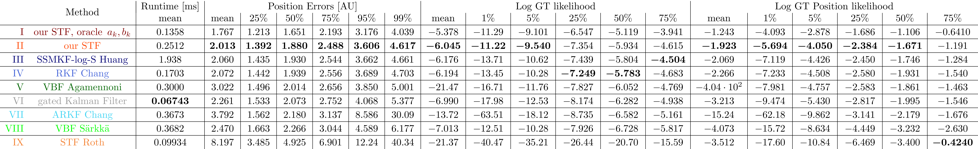

In [8]:
try:
    src.eval.simulate.show_latex(table, packages=["amsmath","multirow","bm","xcolor"], math=True)
except NameError:
    print("Display of the rendered table would require MyPuDoc.\n"
          +"Just open the generated latex file 'data/figures/table.pdf' instead.")

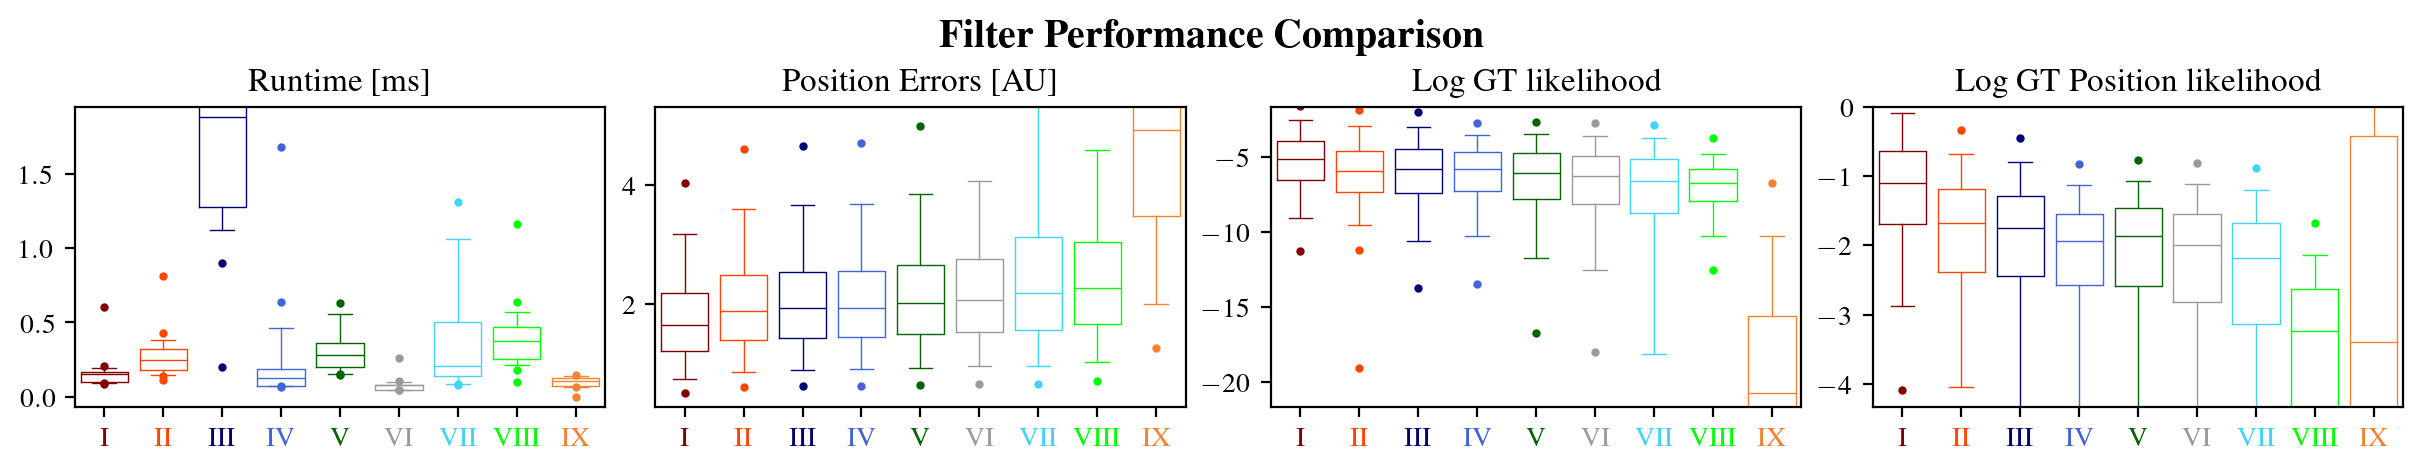

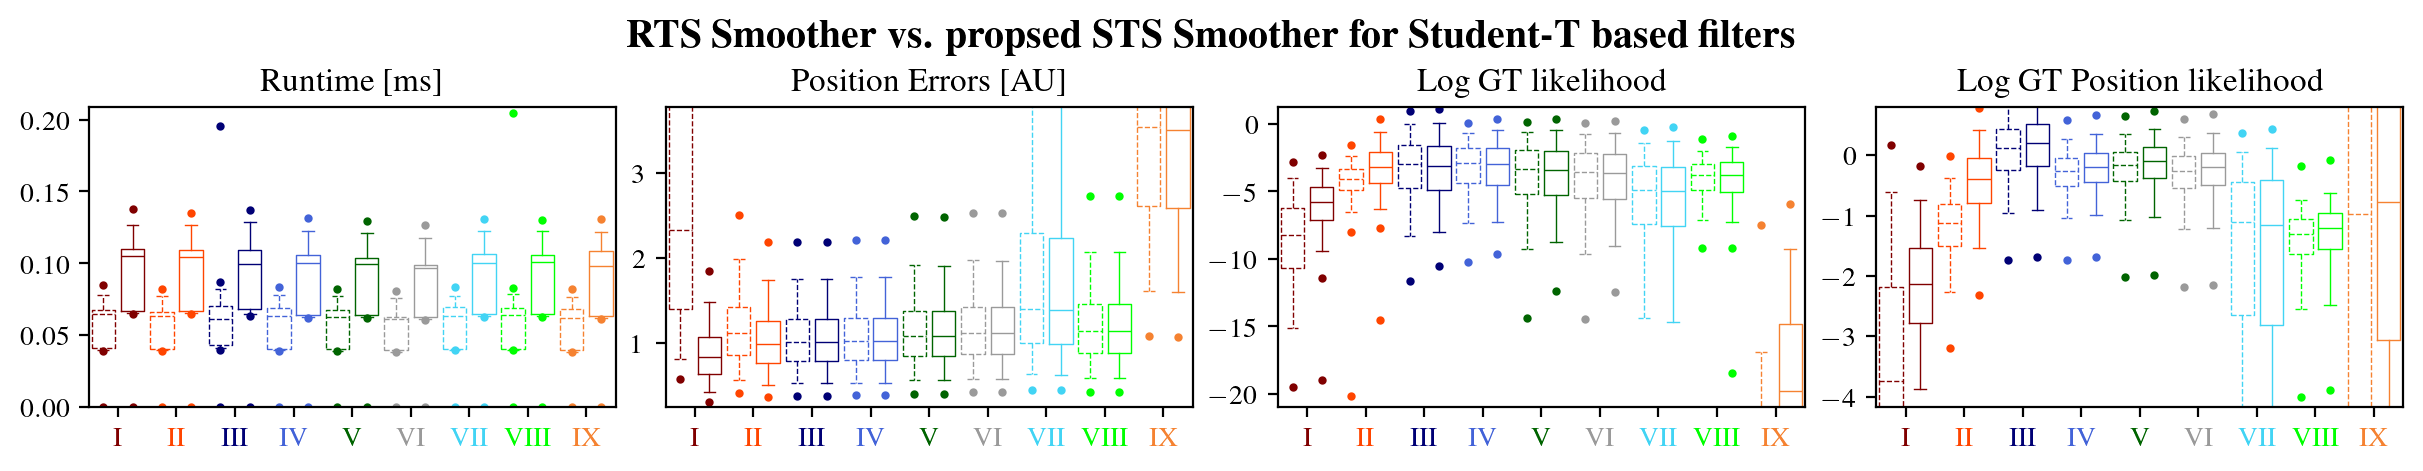

In [9]:
fig, ax = plt.subplots(1,4, figsize=(12,2), dpi=200, constrained_layout=True)
ticklabels = []
fig.suptitle("\\textbf{Filter Performance Comparison}", fontsize="x-large", y=1.1)
src.eval.simulate.make_boxplot(results=best_results, ax=ax[0], categories="comp_time_filter", maxboxoutlier=5)
src.eval.simulate.make_boxplot(results=best_results, ax=ax[1], categories="euc_error")
src.eval.simulate.make_boxplot(results=best_results, ax=ax[2], categories="likelihoods")
src.eval.simulate.make_boxplot(results=best_results, ax=ax[3], categories="likelihoods_pos")
fig.savefig("../data/figures/Filter Performance Comparison.svg")
fig.savefig("../data/figures/Filter Performance Comparison.pdf")

fig2, ax2 = plt.subplots(1,4, figsize=(12,2), dpi=200, constrained_layout=True)
fig2.suptitle("\\textbf{RTS Smoother vs. propsed STS Smoother for Student-T based filters}", fontsize="x-large", y=1.1)
src.eval.simulate.make_boxplot(results=best_results, ax=ax2[0], categories=["comp_time_smoother_RTS","comp_time_smoother_STS",])
ax2[0].set_ylim(0,1.5*ax2[0].get_ylim()[1])
src.eval.simulate.make_boxplot(results=best_results, ax=ax2[1], categories=["euc_error_RTS","euc_error_STS",])
src.eval.simulate.make_boxplot(results=best_results, ax=ax2[2], categories=["likelihoods_RTS","likelihoods_STS",])
src.eval.simulate.make_boxplot(results=best_results, ax=ax2[3], categories=["likelihoods_pos_RTS","likelihoods_pos_STS",])
fig2.savefig("../data/figures/RTS Smoother vs. propsed STS Smoother.svg")
fig2.savefig("../data/figures/RTS Smoother vs. propsed STS Smoother.pdf")